# ⚽ Expected vs. Reality: Is xG a True Predictor of Goals & Can Teams Use xG to Gain Tactical Insight?
---

## **📊 Finishing Efficiency: Do the Best Teams Take Their Chances?**

In football, **chance creation is only half the battle**—what truly defines success is how well teams convert those chances into goals. Some teams may consistently outperform their xG, while others struggle despite generating plenty of opportunities.

### **Why This Matters** 🎯  
Conventional wisdom suggests that **elite teams are more clinical** because they have the highest-quality finishers. No bigger example right now than Manchester City's Erling Haaland, who is breaking all kinds of scoring records. The expectation is that as league ranking improves, so too should a team's **goal-to-xG ratio**—indicating **superior finishing ability**.

### **Hypothesis** 🔬  
> **Higher-ranked teams will have a better goal-to-xG ratio, as elite clubs invest in top attacking talent, leading to superior finishing.**  

But is this actually the case? Do the best teams truly take their chances more efficiently? Or are some clubs outperforming expectations while others fall short?

---

### **What This Notebook Will Explore** 🔍  
1️⃣ **Goal Efficiency** – Which teams scored more (or less) than expected based on xG?  
2️⃣ **League Position vs. Finishing** – Is there a clear link between league ranking and finishing ability?  
3️⃣ **Overperformers & Underperformers** – Who were the most clinical teams? Who wasted the most chances?  

Through this analysis, we aim to determine whether **clinical finishing separates the best from the rest**—or if other factors are at play.  



##### Before we dive into analyzing team efficiency, we first need to process the raw data and calculate the necessary metrics to evaluate how clinical teams were in front of goal.

## 📌 1: Gather all the libraries and Data Required 🔄

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

from Team_Name_Formatting import shorten_team_name


#read in the cleansed data
df = pd.read_csv(r'C:\Users\d_par\OneDrive\Desktop\Danny\2025\Data Science\Portolio Projects\prem-xg-analysis\Data\cleaned_prem_data.csv')

#read in the league table put together in cleasning.py
league_table = pd.read_csv(r'C:\Users\d_par\OneDrive\Desktop\Danny\2025\Data Science\Portolio Projects\prem-xg-analysis\Data\Rankings.csv')

### Step 1: Calculate The xG to Goals Ratio for Each Team and Store in a Table.

In [191]:
# Calculate the total xG and goals for each team
home_xg_goals = df.groupby('Home')[['Home_xg', 'Home_Goals']].sum().reset_index()
away_xg_goals = df.groupby('Away')[['Away_xg', 'Away_Goals']].sum().reset_index()

# Merge home and away stats into a single DataFrame
team_stats = home_xg_goals.merge(
    away_xg_goals,
    left_on='Home',
    right_on='Away',
    suffixes=('_home', '_away')
)

# Calculate total xG and goals for each team over the season
team_stats['Total_xG'] = team_stats['Home_xg'] + team_stats['Away_xg']
team_stats['Total_Goals'] = team_stats['Home_Goals'] + team_stats['Away_Goals']

# Calculate the xG:Goals ratio
team_stats['xG_to_Goals_Ratio'] =   team_stats['Total_xG'] / team_stats['Total_Goals']

#Sort the table by rankings
team_stats = team_stats.sort_values(by='xG_to_Goals_Ratio', ascending=True)

#Format columns before displaying
team_stats = team_stats.rename(columns={'Home': 'Team'}) # rename column
team_stats['Total_xG'] = team_stats['Total_xG'].astype(int)  # Convert xG to integer
team_stats['xG_to_Goals_Ratio'] = team_stats['xG_to_Goals_Ratio'].map('{:.2f}'.format)  # Round xG ratio to 2 decimal places




## Step 2: Disaply the raw data

- The below table shows the total amount of xG and actual goals scored for each team, along with a ratio value that represents **how much xG each team needed on average to score a goal**

In [194]:

#display the raw data
display(team_stats[['Team', 'Total_Goals', 'Total_xG', 'xG_to_Goals_Ratio']].style.hide(axis="index"))

Team,Total_Goals,Total_xG,xG_to_Goals_Ratio
Luton Town,52,42,0.81
Aston Villa,76,63,0.84
Arsenal,91,76,0.84
Manchester City,96,80,0.84
Crystal Palace,57,48,0.85
West Ham,60,52,0.88
Newcastle Utd,85,76,0.90
Tottenham,74,68,0.92
Fulham,55,50,0.92
Wolves,50,47,0.94


### Inital Thoughts

- A few surprising results jump out straight away, with Luton actually ranking first in taking of shooting chances. However they did not create enough xG for their proven finishing ability to keep them up.
- Liverpool are found quite low down the list, despite having some of the best attacking players in the world like Mo Salah.
- Everton massively stand out at the bottom, needing more than 0.2 xG on average than any other team to score a goal.

### Step 2: Prepare the data for visualisation
- To see the data clearer and evaluate the hypothesis made at the start of this notebook, we will produce a Rank Shift Chart.
- This will visually demonstrate how teams differ in their league ranking versus their finishing efficiency ranking, with arrows showing the direction of movement.
- First, the data needs to be formatted, which is done in the cell below

In [198]:
# Select relevant columns and rename
team_ratio_stats = team_stats[['Team', 'Total_xG', 'Total_Goals', 'xG_to_Goals_Ratio']]


team_ratio_stats = team_ratio_stats.merge(
    league_table[['Team','Ranking']],
    on='Team')

team_ratio_stats['Ratio Ranking'] = team_ratio_stats.index + 1

#calulate the correlation between league rank and xg conversion rank
correlation = team_ratio_stats['Ranking'].corr(team_ratio_stats['Ratio Ranking'])

#Sort the table by rankings
team_ratio_stats = team_ratio_stats.sort_values(by='Ranking', ascending=False)


# Update team names with unique short identifiers for Manchester teams
team_ratio_stats['Short Team Name'] = team_ratio_stats['Team'].apply(
    lambda x: 'MC' if x == 'Manchester City' else 'MU' if x == 'Manchester Utd' else x[:3]
)


## Step 3: Create the Visualisation

- Now we have all the data, its time to display the  Rank Shift Chart.
- Arrows indicate movement:

    - Green arrows → A team performed better in xG efficiency than their league finish suggests (i.e., they finished worse than their finishing ability).

    - Red arrows → A team underperformed in xG efficiency relative to their league position, meaning they relied on other factors (defense, luck, game management, etc.) to achieve their final position.

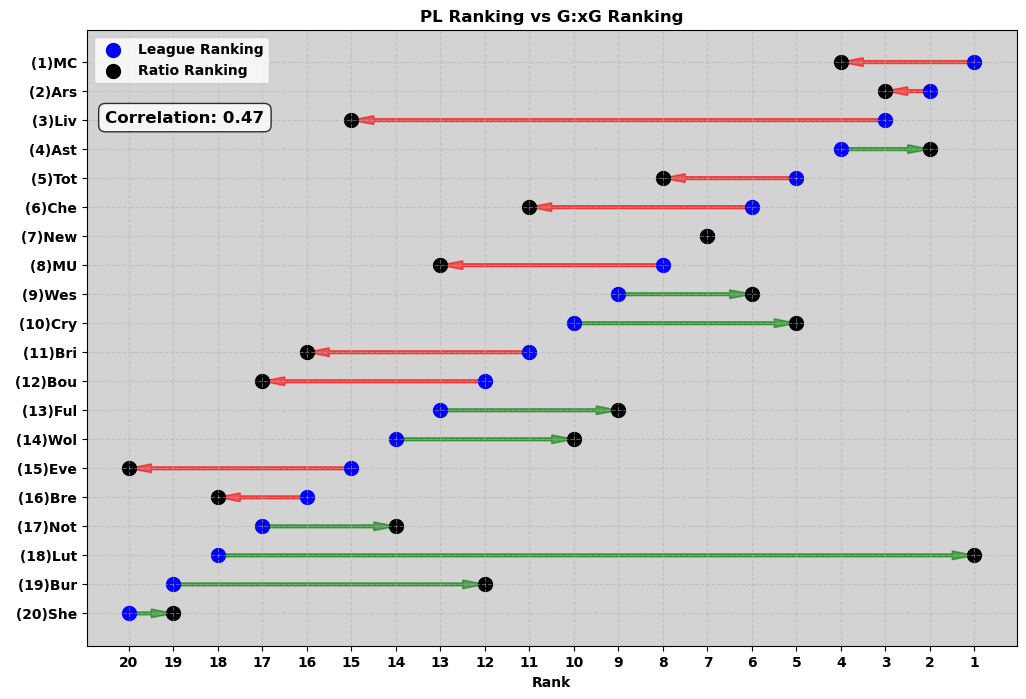

In [201]:
# Create a numeric mapping for team names
team_ratio_stats['Numeric Y'] = range(len(team_ratio_stats), 0, -1)

# Create the dot plot
plt.figure(figsize=(12, 8))

# Plot lines with arrows and color coding based on ranking comparison
for _, row in team_ratio_stats.iterrows():
    line_color = 'green' if row['Ratio Ranking'] < row['Ranking'] else 'red'
    dx = row['Ratio Ranking'] - row['Ranking']  # Difference for arrow direction
    plt.arrow(row['Ranking'], row['Numeric Y'], dx, 0, 
              color=line_color, alpha=0.6, width=0.1, head_width=0.3, head_length=0.5, length_includes_head=True)

# Plot league ranking points
plt.scatter(team_ratio_stats['Ranking'], team_ratio_stats['Numeric Y'], color='blue', label='League Ranking', s=100)

# Plot ratio ranking points
plt.scatter(team_ratio_stats['Ratio Ranking'], team_ratio_stats['Numeric Y'], color='black', label='Ratio Ranking', s=100)

# Set y-axis labels back to team names
plt.yticks(
    ticks=team_ratio_stats['Numeric Y'], 
    labels=" (" + team_ratio_stats['Ranking'].astype(str) + ")" + team_ratio_stats['Short Team Name'], 
    fontweight='bold'
)

# Add labels, title, and legend
plt.xlabel('Rank', fontweight='bold')
plt.title('PL Ranking vs G:xG Ranking', fontweight='bold')

plt.text(
    0.02, 0.85,  # Adjusted Position (move it slightly down to align with legend)
    f'Correlation: {correlation:.2f}',  # Display correlation rounded to 2 decimal places
    transform=plt.gca().transAxes,  # Ensure positioning relative to the figure
    fontsize=12, fontweight='bold', color='black',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.4')  # ✅ Match legend styling
)

plt.rcParams['font.weight'] = 'bold'
plt.legend()
plt.gca().set_facecolor('#D3D3D3')  # Sets the background color to dark gray
plt.gca().invert_yaxis()  # Ensures rank 20 is at the bottom of the y-axis
plt.gca().invert_xaxis()  # Reverse x-axis for ranking order
plt.xticks(ticks=range(1, 21, 1))  # Sets x-axis ticks to go up in increments of 1

plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

## **Conclusion: Evaluating the Hypothesis**

- While a moderate correlation (0.47) supports the idea that better teams tend to be more clinical, there were **notable exceptions** like Luton. This suggests that while finishing ability matters, other factors like **chance creation and defensive stability** also play significant roles in final league standings.

### **Key Takeaways:**
- **Elite teams generally finished better**: The top-performing teams in the league largely had strong xG-to-goal ratios, reinforcing the expectation that better squads convert chances more efficiently.
- **Ranking shifts, but overall tiers remain** – While some teams **moved up or down significantly** in the efficiency rankings, the general trend remained: **higher-ranked teams still tended to be near the top, and lower-ranked teams near the bottom**.
- **Luton: The biggest standout** – Despite being relegated, **Luton were the most clinical side in the league** when presented with chances. This suggests that their downfall was **not due to wastefulness in front of goal**, but rather a lack of **enough opportunities** or **conceding too many at the other end**.
---

## **What’s Next? Rebuilding the League Table Based on xG**

So far, we’ve examined **xG creation and concession**, followed by **how clinical teams are with regards to their xG**.  

However, as the results have shown, **xG isn’t everything**. A team may appear to  create more quality chances than they concede, but **this doesn’t always translate to their final league position**.   

But **what if it did? What if xG truly dictated league standings, how different would the table look?**  

In the next notebook, we will **reconstruct the 2023/24 Premier League table—if games were decided purely by xG.**  

This will reveal:  
- Which teams were **fortunate or unfortunate** in terms of actual results vs. xG expectations.  
- How **overperformers and underperformers** shaped the real table.  
 
This analysis will help **separate luck, finishing variance, and defensive resilience** from pure chance quality. Let’s see how different the season could have looked.  